# Project 1: Digit Classification with KNN and Naive Bayes

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
#import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Additional Imports
import matplotlib.pyplot as plt
import pandas as pd

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/anaconda3/envs/w207/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/envs/w207/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]


data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

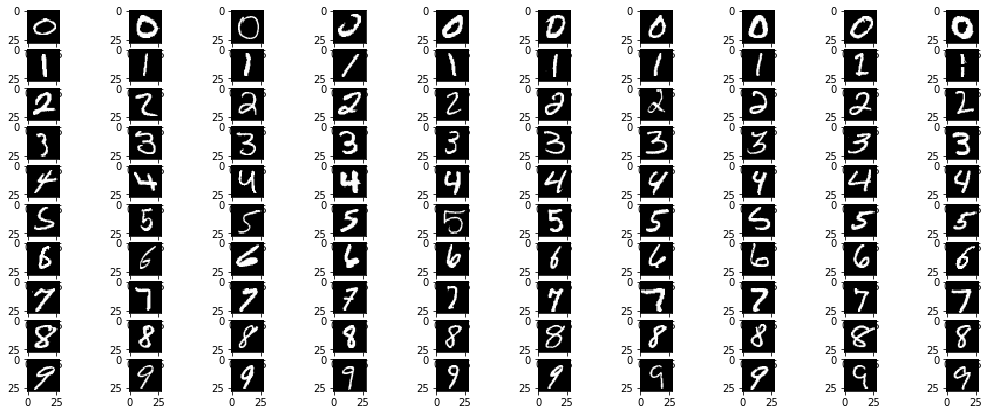

In [3]:
def P1_DisplaySampleMatrix(num_examples, X_array, Y_array):
    """P1_DisplaySampleMatrix is a function that processes and displays a dynamic grid that displays
    a sepcified number of samples across digits.
    
    Please note that this function was only developed with the homework assignment in mind.  Other ways to improve 
    this function should also focus on adding additional parameters to specify what kind of digits the user may want. 

    Args:
        num_examples (int): The number of samples to display across digits.  
        Note that num_examples is also the upper limit for 
        the digit of interest.  If num_examples = 5, then a 5 by 5 grid will display 5 samples of digits 0-4. 
        
        X_array (float): The matrix/array containing the training set
        
        Y_array (float): The matrix/array containing the label set

    Returns:
        visualization object (plt): A matplotlib graphic that displays the grid

    """
    
    # Create column names for pandas processing and manipulation
    feat_cols = ['pixel_feature'+str(i) for i in range(X.shape[1])]
    
    
    df_mnist = pd.DataFrame(X_array,columns=feat_cols) # cast as pandas
    df_mnist['label'] = Y_array
    
    
    # Since the prior code block reshuffles the X and Y objects, I will implement generic sorting and 
    # leverage this in creating a way to dynanmically get the appropriate samples.  
    # Note: This is a naive implementation. 
    df_mnist = df_mnist.sort_values('label')# sort by label
    
    grouped = df_mnist.groupby('label',as_index=False,group_keys = False) # aggregate by the label class
    df_mnist_processed = grouped.apply(lambda x: x.sample(n = num_examples)).reset_index() #random sample without replacement


    plt.gray() # set gray color map
    fig = plt.figure(figsize=(18,7))
    
    #Loop through each row and add num_examples to subplot
    for i in range(0,num_examples*num_examples):
        ax = fig.add_subplot(num_examples,num_examples,i+1)
        ax.imshow(df_mnist_processed[feat_cols].iloc[i,0:785].values.reshape((28,28)).astype(float))

    return(plt.show())

P1_DisplaySampleMatrix(10, X_array = X, Y_array = Y)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def P2_kvalue_search(k_values):
    """P2_kvalue_search is a wrapper function that evaluates multiple KNN models specified by a given list.
    
    Please note that this function was only developed with the homework assignment in mind.  Other ways to improve 
    this function should also focus on adding additional parameters to specify what kind of digits the user may want. 

    Args:
        k_values (list): List of k_values (int)

    Returns:
        text/string: Classification Report and Accuracy on the dev set

    """
    
    for i in k_values:
        
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(mini_train_data, mini_train_labels) 
        predict_output = neigh.predict(dev_data)

        #neigh.predict_proba(dev_data)
        target_names = ['class 0', 'class 1', 'class 2',
               'class 3', 'class 4', 'class 5',
               'class 6', 'class 7', 'class 8',
               'class 9']
        print("KNN Parameter: %s" % (i))
        print(classification_report(dev_labels, predict_output, target_names = target_names))
        print("Accuracy Dev Set: %s \n" % accuracy_score(dev_labels, predict_output))
        ### STUDENT END ###

k_values = [1,3,5,7,9]
P2_kvalue_search(k_values)


KNN Parameter: 1
             precision    recall  f1-score   support

    class 0       0.91      0.98      0.94        99
    class 1       0.89      1.00      0.94       105
    class 2       0.99      0.79      0.88       102
    class 3       0.77      0.87      0.82        86
    class 4       0.89      0.82      0.85       104
    class 5       0.93      0.84      0.88        91
    class 6       0.94      0.96      0.95        98
    class 7       0.89      0.92      0.90       113
    class 8       0.94      0.88      0.91        96
    class 9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Accuracy Dev Set: 0.888 

KNN Parameter: 3
             precision    recall  f1-score   support

    class 0       0.90      1.00      0.95        99
    class 1       0.81      1.00      0.89       105
    class 2       0.95      0.81      0.88       102
    class 3       0.69      0.84      0.75        86
    class 4       0.88      0.85   

ANSWER:

The accuracy for each k value on the dev set is given above, we can see that K-NN of 1 and 5 did the best in terms of accuracy.  

We can also see the precision, recall, f1, and support metrics for each model run.  

Classes 1, 2, 4, 9 seem to have particular difficulty in terms of digit classification.  These classes exhibit relatively low precision or recall. Class 1 in particular seems to have low precision and thus likely a larger False Positive rate.  

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
import time
def P3(train_sizes, accuracies):
    """P3 wrapper function that reports dev set accuracy for various training set sizes.

    Args:
        train_sizes(list): List of sizes (int)

    Returns:
        text/string: Prints time for training size
        
        accuracies(list): returns list of accuracies

    """

    for i in train_sizes: 
        t0 = time.time() #timer
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(mini_train_data[0:i], mini_train_labels[0:i]) 
        predict_output = neigh.predict(dev_data)
        t1 = time.time()
        print("Time for Train Size %s: %s" % (i,t1-t0))#report timer difference
        accuracies.append(accuracy_score(dev_labels, predict_output))
    return(accuracies)

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
output = P3(train_sizes, accuracies)

print(output)

Time for Train Size 100: 0.120427846909
Time for Train Size 200: 0.249668836594
Time for Train Size 400: 0.507704019547
Time for Train Size 800: 0.991477966309
Time for Train Size 1600: 1.38300085068
Time for Train Size 3200: 1.36150503159
Time for Train Size 6400: 1.42349886894
Time for Train Size 12800: 1.41760993004
Time for Train Size 25000: 1.32685112953
[0.71999999999999997, 0.78600000000000003, 0.84099999999999997, 0.88400000000000001, 0.88800000000000001, 0.88800000000000001, 0.88800000000000001, 0.88800000000000001, 0.88800000000000001]


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math


def P4(n=60000):
    
    """P4 wrapper function that generates predictions from fitting a regression model that predicts accuracy from 
    training size.

    Args:
        train_size (int): input training size to generate prediction

    Returns:
        output1: Prediction of model accuracy given train size

    """
    lr = linear_model.LinearRegression()
    training_trainingsize = np.array(train_sizes)
    y = np.array(accuracies)
    lm_fit01 = lr.fit(training_trainingsize.reshape(-1, 1), accuracies)
    output1 = lm_fit01.predict ([[n]])
    return(output1)
    
    
print(P4())

def sigmoid_transform(x):
  return (1/(1 + math.exp(-x)))

print("Sigmoid Scaling: %s" % sigmoid_transform(P4()))


[ 1.02149154]
Sigmoid Scaling: 0.735263031349


ANSWER:

A main issue with using lm in this use case is that the input variable, accuracy, is defined on a probabalistic scale and given the strong linear assumptions of linear regression, an input of 60000 would result in a prediction of 1.03 or greater than 100% which is unrealistic and not useful for interpreation. 

While there are many interesting ways of transforming the data, one simple way would be to borrow a concept from logitic regression and apply sigmmoid transform on the output of the model.  The sigmoid transformation essentially puts everything on a probalistic scale that would align better with the interpreting the original linear regression model.  By using this kind of transformation, the expected values would be within 0.0-1.0 and wouldn't exceed 100%. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


array([ 4.,  3.,  6.,  8.,  6.,  2.,  4.,  4.,  3.,  8.,  6.,  4.,  6.,
        5.,  1.,  2.,  1.,  6.,  5.,  6.,  1.,  2.,  0.,  5.,  4.,  0.,
        7.,  3.,  7.,  3.,  6.,  5.,  9.,  0.,  1.,  7.,  2.,  1.,  7.,
        2.,  4.,  0.,  5.,  6.,  6.,  4.,  6.,  0.,  8.,  2.,  1.,  0.,
        7.,  8.,  1.,  1.,  6.,  4.,  1.,  7.,  1.,  8.,  1.,  1.,  7.,
        6.,  9.,  6.,  7.,  7.,  4.,  3.,  3.,  8.,  0.,  2.,  6.,  6.,
        5.,  3.,  8.,  9.,  4.,  4.,  8.,  0.,  4.,  3.,  5.,  3.,  9.,
        3.,  1.,  0.,  9.,  7.,  0.,  0.,  3.,  3.,  4.,  9.,  8.,  9.,
        8.,  3.,  6.,  0.,  6.,  3.,  4.,  1.,  5.,  2.,  9.,  0.,  7.,
        0.,  9.,  7.,  5.,  7.,  9.,  4.,  8.,  0.,  6.,  9.,  3.,  1.,
        4.,  5.,  8.,  5.,  3.,  3.,  5.,  9.,  8.,  5.,  5.,  6.,  6.,
        7.,  2.,  5.,  6.,  8.,  0.,  8.,  8.,  0.,  3.,  9.,  3.,  6.,
        5.,  3.,  7.,  0.,  7.,  3.,  5.,  0.,  2.,  3.,  8.,  2.,  0.,
        8.,  3.,  1.,  1.,  9.,  0.,  6.,  7.,  7.,  9.,  8.,  9

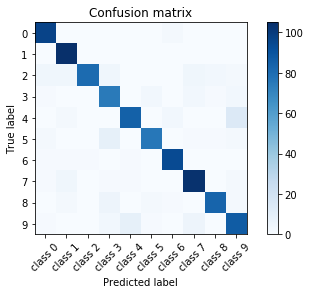

In [12]:
def P5():
    
    """P5 is a procedural code block that generates the CM for problem 5. 

    """
    cmap=plt.cm.Blues

    neigh_1 = KNeighborsClassifier(n_neighbors=1)
    neigh_1.fit(mini_train_data, mini_train_labels) 
    predict_output = neigh_1.predict(dev_data)


    cm = confusion_matrix(dev_labels, predict_output) 
    title='Confusion matrix'
    target_names = ['class 0', 'class 1', 'class 2',
               'class 3', 'class 4', 'class 5',
               'class 6', 'class 7', 'class 8',
               'class 9']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(cm)
    return(predict_output)


P5()

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


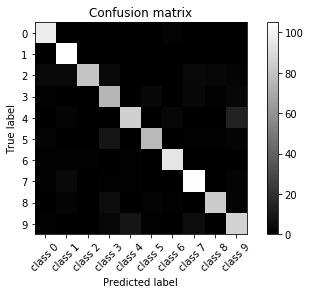

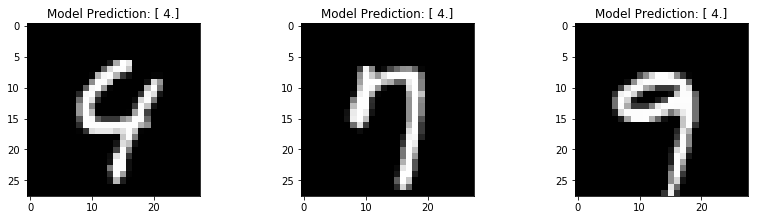

In [13]:
predict_output = P5()

df_pred_labels = pd.DataFrame(predict_output, columns = ["pred_labels"]).reset_index(drop = True)
dflabels = pd.DataFrame(dev_labels, columns=['labels']).reset_index(drop=True)

df_data = pd.DataFrame(dev_data).reset_index(drop=True)

df_dev_total = pd.concat([dflabels,df_pred_labels,df_data], axis = 1)

examples_df = pd.DataFrame(df_dev_total.query("pred_labels == 4.0 & labels != 4.0"))

plt.gray() # set gray color map
fig = plt.figure(figsize=(18,7))
    
#Loop through each row and add num_examples to subplot
#feat_cols = [str(i) for i in range(dev_data.shape[1])]
ax = fig.add_subplot(2,1,1, title = "Model Prediction: %s" % (np.array(examples_df)[1,1:2]))
plt.imshow(np.array(examples_df)[5,2:786].reshape((28,28)).astype(float))

ax = fig.add_subplot(2,2,1, title = "Model Prediction: %s" % (np.array(examples_df)[2,1:2]))
plt.imshow(np.array(examples_df)[2,2:786].reshape((28,28)).astype(float))

ax = fig.add_subplot(2,2,2, title = "Model Prediction: %s" % (np.array(examples_df)[3,1:2]))
plt.imshow(np.array(examples_df)[3,2:786].reshape((28,28)).astype(float))


Answer: Digits 4 and 9 tend to have the highest FP/FN counts when refering to the CM.  ABove are some examples of falsely classified images. 

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [14]:
from scipy.ndimage.filters import gaussian_filter
def P6():

    dev_data_blurred = gaussian_filter(dev_data, sigma = 1)
    train_data_blurred = gaussian_filter(mini_train_data, sigma = 1)

    def knn_validate_blur(train_data, train_labels, dev_data, dev_label):
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(train_data, train_labels)
        predict_output = neigh.predict(dev_data)
        print("KNN Parameter: %s" % (5))
        print(classification_report(dev_label, predict_output))
        print("Accuracy Dev Set: %s \n" % accuracy_score(dev_labels, predict_output))
        return(accuracy_score(dev_labels, predict_output))

    case01 = knn_validate_blur(train_data = train_data_blurred,train_labels = mini_train_labels, dev_data = dev_data, dev_label = dev_labels)
    case02 = knn_validate_blur(train_data = mini_train_data,train_labels = mini_train_labels, dev_data = dev_data_blurred, dev_label = dev_labels)
    case03 = knn_validate_blur(train_data = train_data_blurred,train_labels = mini_train_labels, dev_data = dev_data_blurred, dev_label = dev_labels)
    return([case01,case02,case03])


P6()

KNN Parameter: 5
             precision    recall  f1-score   support

        0.0       0.76      0.99      0.86        99
        1.0       0.72      0.99      0.84       105
        2.0       0.96      0.76      0.85       102
        3.0       0.70      0.83      0.76        86
        4.0       0.89      0.69      0.78       104
        5.0       0.96      0.70      0.81        91
        6.0       0.88      0.89      0.88        98
        7.0       0.80      0.88      0.84       113
        8.0       0.92      0.68      0.78        96
        9.0       0.75      0.73      0.74       106

avg / total       0.83      0.81      0.81      1000

Accuracy Dev Set: 0.815 

KNN Parameter: 5
             precision    recall  f1-score   support

        0.0       0.75      0.57      0.64        99
        1.0       0.37      0.96      0.53       105
        2.0       0.69      0.28      0.40       102
        3.0       0.67      0.45      0.54        86
        4.0       0.63      0.47   

[0.81499999999999995, 0.54500000000000004, 0.53100000000000003]

ANSWER:

Preprocess the training data but not the dev data did the best given the same KNN model with >.80 accuracy. 

It's interesting to note that given blurred mnist data for training, a knn model does well predicting on the dev data set.  However, the model doesn't generalize well on blurred_dev data which may hint at overfitting or some tendency to fit too much on pixel noise. More data samples and perhaps smoothing can help blurring of the both independent and dependent variables.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [15]:
from sklearn import preprocessing

def P7_naive_bayes():
    '''
    naive bayes (gaussian)
    
    '''
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB()
    y_pred = gnb.fit(mini_train_data, mini_train_labels).predict(dev_data)
    print(classification_report(dev_labels, y_pred))
    print("Accuracy Dev Set: %s \n" % accuracy_score(dev_labels, y_pred))
    return(accuracy_score(dev_labels, y_pred))


def P7_binarized_bayes():
    '''
    naive bayes (bernoulli)
    
    '''
    from sklearn.naive_bayes import BernoulliNB
    bnb = BernoulliNB(binarize = 0.99)
    
    #binarizer = preprocessing.Binarizer(threshold=0.0)
    #binarized_data = binarizer.transform(mini_train_data)
    #binarized_dev_data = binarizer.transform(dev_data)
    y_pred = bnb.fit(mini_train_data, mini_train_labels).predict(dev_data)
    
    print(classification_report(dev_labels, y_pred))
    print("Accuracy Dev Set: %s \n" % accuracy_score(dev_labels, y_pred))
    return(accuracy_score(dev_labels, y_pred))


def P7_multinomial_bayes():
    from sklearn.naive_bayes import MultinomialNB
    
    def miniBinerizer(train_df = mini_train_data):
        # I wasn't sure of a good way to 3-way binarize the data
        # so I created two numpy arrays and added them together
        # so that any pixel that is 1 is 2, 0 is 0, and anything else is 1.
        binarizer1 = preprocessing.Binarizer(threshold= 0.99999)
        binarizer2 = preprocessing.Binarizer(threshold= 0.0)
        binarized = binarizer1.transform(train_df)
        binarized_to_add = binarizer2.transform(train_df)
        total = binarized + binarized_to_add
        return(total)
    
    mnb = MultinomialNB()
    y_pred = mnb.fit(miniBinerizer(mini_train_data), mini_train_labels).predict(miniBinerizer(dev_data))
    
    print(classification_report(dev_labels, y_pred))
    print("Accuracy Dev Set: %s \n" % accuracy_score(dev_labels, y_pred))
    return(accuracy_score(dev_labels, y_pred))


print(P7_naive_bayes())
print(P7_binarized_bayes())
print(P7_multinomial_bayes())
    

             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79        99
        1.0       0.82      0.89      0.85       105
        2.0       0.62      0.39      0.48       102
        3.0       0.62      0.45      0.52        86
        4.0       0.80      0.39      0.53       104
        5.0       0.52      0.36      0.43        91
        6.0       0.69      0.88      0.77        98
        7.0       0.84      0.48      0.61       113
        8.0       0.41      0.61      0.49        96
        9.0       0.47      0.88      0.61       106

avg / total       0.66      0.62      0.61      1000

Accuracy Dev Set: 0.621 

0.621
             precision    recall  f1-score   support

        0.0       0.87      0.86      0.86        99
        1.0       0.42      0.93      0.57       105
        2.0       0.84      0.64      0.73       102
        3.0       0.67      0.62      0.64        86
        4.0       0.87      0.58      0.69       104
        5.

ANSWER:

Yes, multiclass assumptions improve performance.  This makes sense after considering what Naive Bayes is. 
Naive Bayes classifier relies on the naive assumption that there is conditional independence for each of the features in the model, while Multinomial Naive Bayes classifier uses a multinomial distribution for each of the features and accounts for potential correlations and realistic dependencies between image/pixelfeatures. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

def P8(alphas):
    '''
    P8 is a function for brute foce grid searching over lambda
    
    arg:
        alphas(float): list of alphas (float)
        
    output:
        GridSearchCV fit estimated
    
    '''

    bnb = BernoulliNB(binarize = 0.0)

    parameters = alphas
    grid_search = GridSearchCV(bnb, parameters, n_jobs=1, verbose=1, cv = 3)

    bnb_grid_store = grid_search.fit(mini_train_data, mini_train_labels)
    return(bnb_grid_store)

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
alphas_0 = {'alpha': [0.0]}
nb = P8(alphas)


nb_0 = P8(alphas_0)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/anaconda3/envs/w207/lib/python2.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [17]:
print nb.best_score_

print nb.best_params_

print nb_0.best_score_

0.821
{'alpha': 0.1}
0.803


ANSWER:  The best alpha from the grid search was 0.1 with an accuracy of ~0.805.  Note that the binary threshold is 0.0, so anything not white(0) space is black (1).

When alpha is 0.1, the performance accuracy drops a little bit. This isn't surprising since no smoothing is being done.  The reason for additive smoothing is to help the data set by introducing observations for each class through smoothing out the categorical classes.  It is useful in scenarious where we have little or not so balanced data and need to prepare for more unseen classes.  No smoothing would lose this benefit and may miss identifying cases correctly and thus lower accuracy slightly.   

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [21]:
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

def P9():
    
    norm_clf = make_pipeline(Normalizer(), GaussianNB())
    y_pred = norm_clf.fit(mini_train_data, mini_train_labels).predict(dev_data)
    
    print(classification_report(dev_labels, y_pred))
    print("Accuracy Dev Set: %s \n" % accuracy_score(dev_labels, y_pred))
    return(accuracy_score(dev_labels, y_pred))

print(P9())


             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79        99
        1.0       0.83      0.89      0.86       105
        2.0       0.61      0.39      0.48       102
        3.0       0.60      0.48      0.53        86
        4.0       0.80      0.41      0.54       104
        5.0       0.51      0.35      0.42        91
        6.0       0.71      0.87      0.78        98
        7.0       0.85      0.50      0.63       113
        8.0       0.40      0.60      0.48        96
        9.0       0.48      0.89      0.62       106

avg / total       0.66      0.62      0.62      1000

Accuracy Dev Set: 0.625 

0.625


ANSWER:

Examing the attributes more in detail reveals that this generative modeling procecess takes the mean and variance of the feature space into account.  Since we are assuming generic gaussian assumptions, it would be more optimal to have a more normalized mean and spread of the data.  Basically, by making the features appear more gaussian-friendly, we can improve the performance of the gaussian model to be as performant as a bernoulli bayes model.  There are many ways of normalizing the mean and variance but for simnplicity I will only perform generic normalization (defult L2) from the sklearn package.  Decomposing and removing components may help with this in addition to normalization/

Note: 
1. theta is an attribute representing mean of each feature per class
2. sigma is an attribute representing variance of each feature per class

Other things that can help would focus on manipulating the distributions of the training data to achieve ideal theta and sigma values. Removing highly collinear pixels would also be useful.   PCA would be helpful in its ability to generate uncorrelated linear components from it's variance, which will be explored later. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

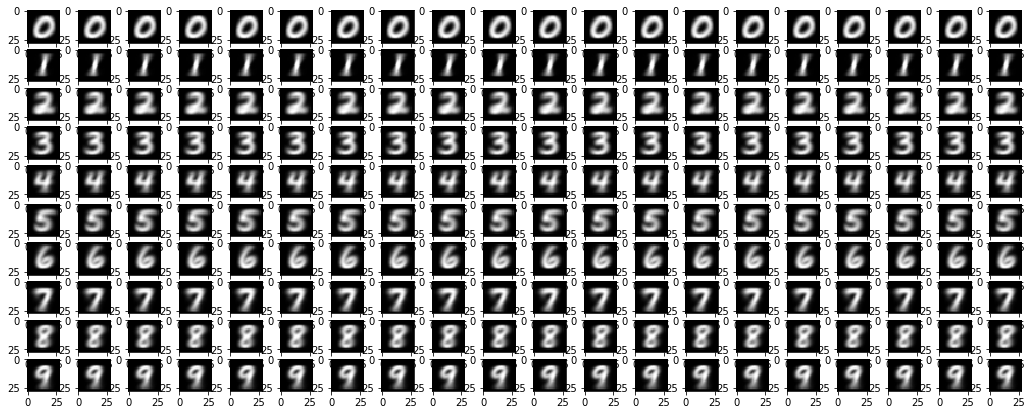

In [23]:
def P10(num_examples = 20):
    
    from sklearn.naive_bayes import BernoulliNB
    bnb = BernoulliNB()
    
    random_limit = np.random.randint(1000,60000) #chose a random range
    generated_image_tmp = []
    
    
    for i in range(0,num_examples):
        binarizer = preprocessing.Binarizer(threshold=0.0)
        binarized_data = binarizer.transform(train_data[0:random_limit])
        binarized_train_data = binarizer.transform(dev_data)

        y_model = bnb.fit(binarized_data, train_labels[0:random_limit])
        y_pred = y_model.predict(binarized_train_data)
        
        generated_image_tmp.append(np.exp(y_model.feature_log_prob_))
        
    plt.gray() # set gray color map
    fig = plt.figure(figsize=(18,7))

    for i in range(0,20):
        ax = fig.add_subplot(10,20,i+1)
        plt.imshow(generated_image_tmp[i][0,].reshape((28,28)))
    
    for i in range(0,20):
        ax = fig.add_subplot(10,20,21+i)
        plt.imshow(generated_image_tmp[i][1,].reshape((28,28)))
    
    for i in range(0,20):
        ax = fig.add_subplot(10,20,41+i)
        plt.imshow(generated_image_tmp[i][2,].reshape((28,28)))

    for i in range(0,20):
        ax = fig.add_subplot(10,20,61+i)
        plt.imshow(generated_image_tmp[i][3,].reshape((28,28)))
    
    for i in range(0,20):
        ax = fig.add_subplot(10,20,81+i)
        plt.imshow(generated_image_tmp[i][4,].reshape((28,28)))

    for i in range(0,20):
        ax = fig.add_subplot(10,20,101+i)
        plt.imshow(generated_image_tmp[i][5,].reshape((28,28)))

    for i in range(0,20):
        ax = fig.add_subplot(10,20,121+i)
        plt.imshow(generated_image_tmp[i][6,].reshape((28,28)))
    
    for i in range(0,20):
        ax = fig.add_subplot(10,20,141+i)
        plt.imshow(generated_image_tmp[i][7,].reshape((28,28)))

    for i in range(0,20):
        ax = fig.add_subplot(10,20,161+i)
        plt.imshow(generated_image_tmp[i][8,].reshape((28,28)))
    
    for i in range(0,20):
        ax = fig.add_subplot(10,20,181+i)
        plt.imshow(generated_image_tmp[i][9,].reshape((28,28)))
    
    

P10()


ANSWER:

The generated digits look readable but each sample looks very similar to other samples.  The original images have more variability in the way the digits were written, however, this looks as if some blurring or averaging was taken place, as if multiple images per digi were superimposed on each other to generate a smoothed out image.  The training digits, referring to P1(), are more variable but looks thinner in terms of pixel/font space taken by the digit.  So in essence, the generated digits can generate digits well, but the cleary have been provessed, downscaled in terms of color, and smoothed out. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [24]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import log_loss
from __future__ import division
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = []
total = []

def P11(buckets, correct, total):
    '''
    P11 takes the maximum posterior, identifies which bucket it belongs to, and returns totals and counts for 
    calculating accuracy. 
    
    args:
    
        buckets(list): list of floats to represent bins
        correct: list of counts for each bin
        correct: list of correctly predicted cases for each bin
        
    return:
        returns the buckets, correct, and total with counts appended.
    
    '''
    bnb03 = BernoulliNB(alpha=0.1, binarize = 0.0)

    bnb_fit03 = bnb03.fit(mini_train_data, mini_train_labels)
    
    #using calibrated classifier which will do a round robin version of multi class accuracy
    bayes_clf = CalibratedClassifierCV(bnb03, method="isotonic", cv="prefit")

    calibrated_bnb = bayes_clf.fit(mini_train_data, mini_train_labels)

    calibrated_output = calibrated_bnb.score(dev_data, calibrated_bnb.predict(dev_data))
    proba_df = pd.DataFrame(calibrated_bnb.predict_proba(dev_data))


    # for each bucket, calculate the proba output, take the true and predict label and 
    # calculate accuracy for each bucket theshold.  
    for i in buckets:
        max_probs = pd.DataFrame(proba_df.max(axis = 1), columns = ["proba"]).reset_index()
        label_val = pd.DataFrame(proba_df.idxmax(axis=1), columns = ["val_label"]).reset_index()
        true_labels = pd.DataFrame(dev_labels, columns = ["true_label"]).reset_index()

        label_proba_table = pd.concat([max_probs["proba"], label_val["val_label"], true_labels["true_label"]], axis = 1)
        #filter out proba within confidence theshold of bucket values
        processed_df = label_proba_table.query("proba < %s" % (i)) #subset using query logi 
        processed_correct_df = processed_df.query("val_label == true_label") #get frame of correct matches to count number of correct rows

        total_tmp = len(processed_df.index)
        correct_tmp = len(processed_correct_df.index)
    
        correct.append(correct_tmp)
        total.append(total_tmp)
        
    return(buckets, correct, total)
        
        
P11(buckets = buckets, correct = correct, total = total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)


p(pred) <= 0.5000000000000    total =  84    accuracy = 0.345
p(pred) <= 0.9000000000000    total = 405    accuracy = 0.602
p(pred) <= 0.9990000000000    total = 867    accuracy = 0.789
p(pred) <= 0.9999900000000    total = 867    accuracy = 0.789
p(pred) <= 0.9999999000000    total = 867    accuracy = 0.789
p(pred) <= 0.9999999990000    total = 867    accuracy = 0.789
p(pred) <= 0.9999999999900    total = 867    accuracy = 0.789
p(pred) <= 0.9999999999999    total = 867    accuracy = 0.789
p(pred) <= 1.0000000000000    total = 867    accuracy = 0.789



ANSWER:

I'm not confident about my way of doing the calibration plot, but it would see that for larger posterior probabilities, the accuracy improves and tapers off after a certain bucket.  So at high bin thesholds the posterior probability reaches a steady state, this could mean that it isn't very sensitive since it maxes out at an accuracy below ~.80.   As the probability/bucket increases past 0.9, the accuracy stops rising and exhibits less sensitivity. I would trust this accuracy more than generic dev set accuracy since it shows theres room for improvement to have a more more ideal reliability curve.  Perhaps some ways of removing spurious information could help. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

             precision    recall  f1-score   support

        0.0       0.89      0.97      0.93        99
        1.0       0.95      0.94      0.95       105
        2.0       0.80      0.78      0.79       102
        3.0       0.73      0.81      0.77        86
        4.0       0.90      0.84      0.87       104
        5.0       0.75      0.76      0.75        91
        6.0       0.92      0.88      0.90        98
        7.0       0.87      0.82      0.85       113
        8.0       0.87      0.88      0.87        96
        9.0       0.84      0.84      0.84       106

avg / total       0.85      0.85      0.85      1000

Accuracy Dev Set -- Model GNB w PCA : 0.853 

             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79        99
        1.0       0.82      0.89      0.85       105
        2.0       0.62      0.39      0.48       102
        3.0       0.62      0.45      0.52        86
        4.0       0.80      0.39      0.53       

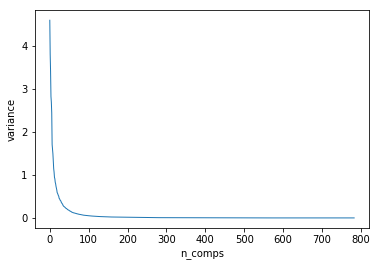

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn import decomposition
from sklearn.preprocessing import Normalizer
from scipy.stats import moment
from sklearn.naive_bayes import GaussianNB

def P12_scree_plot():
    '''
    P12_scree_plot generates scree plot to assess appropriate number of components
    
    '''
    pca = decomposition.PCA()#plot all components
    pca.fit(mini_train_data)
    pca_mini_train_data = pca.transform(mini_train_data)
    # By plotting scree plot, I assessed that the optimal number of components will be
    # between 1-120 components to retain most of the variance. 
    pca.fit(mini_train_data)
    plt.clf()
    plt.plot(pca.explained_variance_, linewidth=1)
    plt.xlabel('n_comps')
    plt.ylabel('variance')


def P12_GNB(benchmark = True, n_comp= 10):
    '''
    P12_GNB creates a GNB model using PCA decomposition.
    
    arg:
        benchmark(bool) : Boolean parameter, if true, train a gneeric GNB to compare main model
        n_comp(int) : Number of components to keep (sorted by decreasing rank)
        
    return:
        Classification report of performance
    
    '''
    gnb = GaussianNB() #initiate naive bayes estimator
    pca_clf = make_pipeline(Normalizer(), decomposition.PCA(n_components=n_comp), GaussianNB())
    
    # Use of pipeline to chain normilization and pca methods prior to the GaussianNB model. 
    y_pred = pca_clf.fit(mini_train_data, mini_train_labels).predict(dev_data)
    print(classification_report(dev_labels, y_pred))
    print("Accuracy Dev Set -- Model GNB w PCA : %s \n" % accuracy_score(dev_labels, y_pred))
    
    #Conditional branch to train a bare version of the model for benchmarking purposes
    if(benchmark == True):
        bare_clf = make_pipeline(GaussianNB())
        y_pred_benchmark = bare_clf.fit(mini_train_data, mini_train_labels).predict(dev_data)
        print(classification_report(dev_labels, y_pred_benchmark))
        print("Accuracy Dev Set -- Baseline GNB Bare: %s \n" % accuracy_score(dev_labels, y_pred_benchmark))

        
P12_scree_plot()
P12_GNB(n_comp = 30)


ANSWER:
    
My goal with this code was to compromise between a form of feature selection and feature engineering with PCA. 
By using PCA, we can convert correlated variables into a set of values of linearly uncorrelated components (known as principle components).  It essentially a way for compressing data and reducing dimensions.  There is sometimes data lose associated with this, however, for this data set it is likely that many pixel features are rather spurious and could have had led to inadvertant overfitting. 

In this examples, the function above compares both a regular GaussianNB model to a custom PCA-GaussianNB model on the dev data set.  By compressing the components down to 30, it appears to improve the accuracy and in general also improve other metrics (precision, recall, f1) by a signficant margin. 